In [29]:
import torch
from torch.utils.data import Dataset
import numpy as np
import os
from PIL import Image
import sys
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
sys.path.append("../")

from utils.hand_detector import get_hands_img
from models.models import CustomHeatmapsModel
from torchvision import transforms
from utils.utils import project_points_3D_to_2D, heatmaps_to_coordinates
from datasets.h2o import H2O_Dataset


IMAGE_N = 500 # Index of image to see

from config import *

In [30]:
config = {  'device': 3,
            'data_dir': '/data/wmucha/datasets/h2o/h2o_CASA',
            "model_path": "/caa/Homes01/wmucha/repos/applied_deep_learning/applied_dl/saved_models/fulldata_SGDmoment_classicval_126",}
dataset = H2O_Dataset(config)

item = dataset[IMAGE_N]

img = item['image_raw']
cam_pose = item['cam_pose']
hand_pose = item['hand_pose']
hand_pose_mano = item['hand_pose_mano']
cam_instr = item['cam_instr']

In [31]:
hand_model = mp.solutions.hands.Hands()

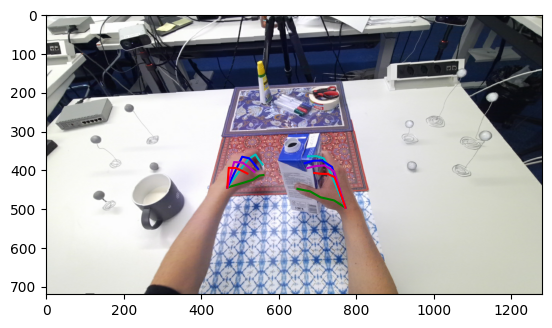

In [32]:
plt.imshow(img)
gt_pts= np.split(hand_pose,[1,64,65,128]) 


hand1 = np.reshape(gt_pts[1], (21,3))
hand2 = np.reshape(gt_pts[3], (21,3))
ptsL = project_points_3D_to_2D(hand1,cam_instr)
ptsP = project_points_3D_to_2D(hand2,cam_instr)

for finger, params in COLORMAP.items():
    plt.plot(
        ptsL[params["ids"], 0],
        ptsL[params["ids"], 1],
        params["color"],
        )

for finger, params in COLORMAP.items():
    plt.plot(
        ptsP[params["ids"], 0],
        ptsP[params["ids"], 1],
        params["color"],
        )

In [33]:
hands_dict = get_hands_img(img, hand_pose, cam_instr = cam_instr, hand_model=hand_model) 


-3
19


In [34]:
imgs = hands_dict['hands_seg']
gts = hands_dict['gt'] 

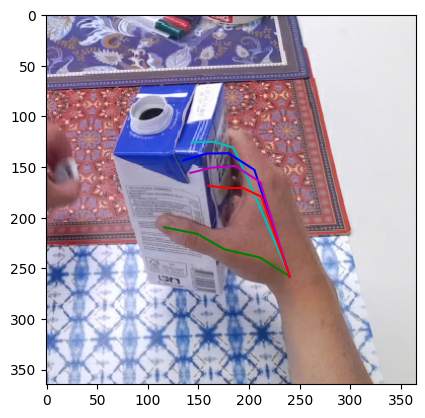

In [35]:
plt.imshow(imgs[0])
pts = gts[0] * imgs[0].size[0]

for finger, params in COLORMAP.items():
    plt.plot(
        pts[params["ids"], 0],
        pts[params["ids"], 1],
        params["color"],
        )

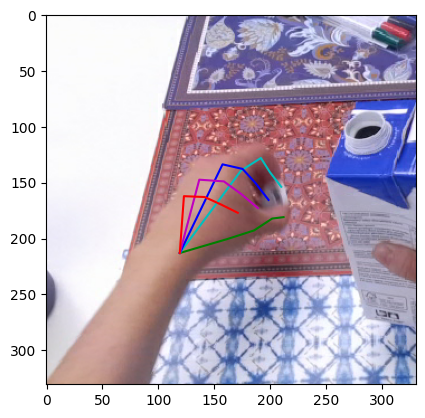

In [36]:
plt.imshow(imgs[1])
pts = gts[1] * imgs[1].size[0]
#TODO draw on image
for finger, params in COLORMAP.items():
    plt.plot(
        pts[params["ids"], 0],
        pts[params["ids"], 1],
        params["color"],
        )

In [37]:

def run_model_on_hands(model, hands):
    
    # apply normalization
    transform = transforms.Compose(
                [
                    transforms.Resize(MODEL_IMG_SIZE),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=TRAIN_DATASET_MEANS, std=TRAIN_DATASET_STDS)
                ]
            )

    inpt1 = transform(hands[0])
    inpt2 = transform(hands[1])

    inpt = torch.stack([inpt1,inpt2], dim=0)
   
    pred_heatmaps = model(inpt)
       
    pred_heatmaps = pred_heatmaps.detach().numpy()
   
    
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    return pred_keypoints



In [38]:
model = CustomHeatmapsModel(3, 21)
model.load_state_dict(
    torch.load(config["model_path"], map_location=torch.device(config["device"]))
)
model.eval()
print("Model loaded")

Model loaded


In [39]:

pred = run_model_on_hands(model,imgs)

torch.Size([2, 3, 128, 128])
(2, 21, 128, 128)


365


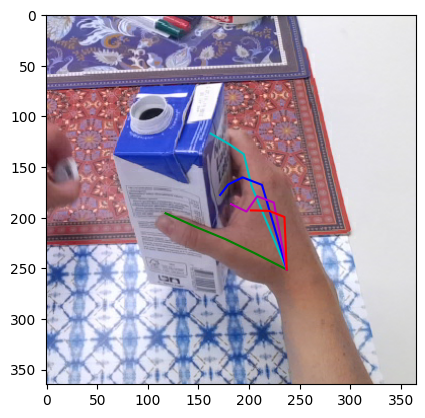

In [41]:
plt.imshow(imgs[0])
print(imgs[0].size[0])
pts = pred[0] * imgs[0].size[0]
#TODO draw on image
for finger, params in COLORMAP.items():
    plt.plot(
        pts[params["ids"], 0],
        pts[params["ids"], 1],
        params["color"],
        )

331


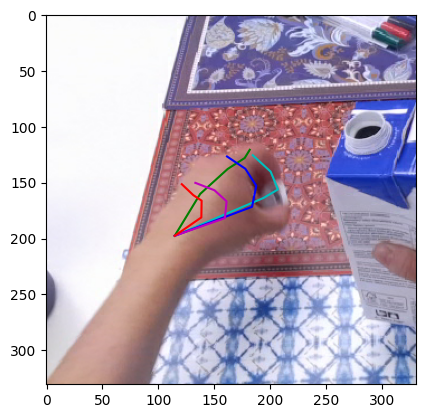

In [42]:
plt.imshow(imgs[1])
print(imgs[1].size[0])
pts = pred[1] * imgs[1].size[0]
for finger, params in COLORMAP.items():
    plt.plot(
        pts[params["ids"], 0],
        pts[params["ids"], 1],
        params["color"],
        )